In [1]:
#%pip install pybamm -q    # install PyBaMM if it is not installed
import os
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
from matplotlib import style
style.use('ggplot')
start = timeit.default_timer()
os.chdir(pybamm.__path__[0]+'/..')
pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.BasicDFNComposite()
chemistry = pybamm.parameter_sets.Chen2020_composite
param = pybamm.ParameterValues(chemistry=chemistry)
# model = pybamm.lithium_ion.DFN()
# param = model.default_parameter_values
param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})
param.update({
    "Maximum concentration in negative electrode of phase 1 [mol.m-3]":28700,
    "Initial concentration in negative electrode of phase 1 [mol.m-3]":23000,
    "Negative electrode mass fraction of phase 1":0.98,
    "Negative electrode diffusivity of phase 1 [m2.s-1]":5.5E-14,
    "Negative electrode diffusivity of phase 2 [m2.s-1]":1.67E-14,
    "Negative electrode mass fraction of phase 2":0.02,
    "Initial concentration in negative electrode of phase 2 [mol.m-3]":277000,
    "Maximum concentration in negative electrode of phase 2 [mol.m-3]":278000,
    })

# initial concentration of graphite 29866 [mol.m-3]
# -> 0.9134 * 25830 + 0.0866 * 275220

C_rates = 1
Q_cell = 5 # [Ah]
period = 1 / C_rates * Q_cell / 5
transition = period / 20
timestep=np.array([0.1, period, 2]) * 3600
points=[41, 201, 201]
t_evals=[]
t0 = 0
for i in range(0,len(timestep)):
    t1 = np.linspace(t0, t0 + timestep[i] - transition, points[i])
    t0 += timestep[i]
    if i < len(timestep)-1:
        t2 = np.linspace(t0 - transition, t0 + transition, 41) # transition points
    else:
        t2 = []
    t_evals=np.concatenate((t_evals, t1 ,t2))

t_evals = np.unique(t_evals)
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rates * capacity  

def I_fun(A):
    def current(t):
        C_rates = 1
        Q_cell = 5 # [Ah]
        period = 1 / C_rates * Q_cell / 5
        timestep=np.array([0.1, period, 2]) * 3600
        k = 5
        rest = pybamm.sigmoid( t , timestep[0], k)
        discharge = pybamm.sigmoid( t , timestep[0] + timestep[1], k) - rest
        return A * discharge
        # return A * (t < period) - A * (t >= period)
        # return A * 0.2 * pybamm.sin(2 * np.pi * t / 7200 )
    return current

param["Current function [A]"] = I_fun(I_load)

sim1 = pybamm.Simulation(
    model,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max = 10),
)
solution = sim1.solve(t_eval = t_evals)
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

2021-08-22 20:49:34,117 - [INFO] parameter_values.process_model(411): Start setting parameters for Doyle-Fuller-Newman model
2021-08-22 20:49:34,388 - [INFO] parameter_values.process_model(501): Finish setting parameters for Doyle-Fuller-Newman model
2021-08-22 20:49:34,391 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2021-08-22 20:49:35,981 - [INFO] discretisation.process_model(239): Finish discretising Doyle-Fuller-Newman model
2021-08-22 20:49:35,982 - [INFO] base_solver.solve(554): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2021-08-22 20:49:35,985 - [INFO] base_solver.set_up(140): Start solver set-up
2021-08-22 20:49:36,684 - [INFO] base_solver.set_up(426): Finish solver set-up
2021-08-22 20:49:54,988 - [INFO] base_solver.solve(802): Finish solving Doyle-Fuller-Newman model (event: Minimum voltage)
2021-08-22 20:49:55,012 - [INFO] base_solver.solve(811): Set-up time: 700.198 ms, Solve time: 15.608 s (of wh

running time: 21.19509819999803s


In [3]:
# plot
plot = pybamm.QuickPlot( solution, [       
        "Current [A]",
        "Terminal voltage [V]",
        "X-averaged negative electrode open circuit potential of phase 1 [V]",
        "X-averaged negative electrode open circuit potential of phase 2 [V]",
    ]
)
plot.dynamic_plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=1.063398495061401, step=0.01063398495061401)…

In [4]:
current = solution["Current [A]"].entries
times = solution["Time [s]"].entries / 3600 - 0.1
voltage = solution["Terminal voltage [V]"].entries
ocp_p1 = solution["X-averaged negative electrode open circuit potential of phase 1 [V]"].entries
ocp_p2 = solution["X-averaged negative electrode open circuit potential of phase 2 [V]"].entries
capacity = current * 0
capacity_max = 0
time_discharge = 0
Q_t = 0
for i in range(1,len(current)):
    Q_t += (current[i] + current[i - 1]) / 2 * (times[i] - times[i-1])
    capacity[i] = Q_t
capacity = Q_cell - capacity

(-0.01, 1.2)

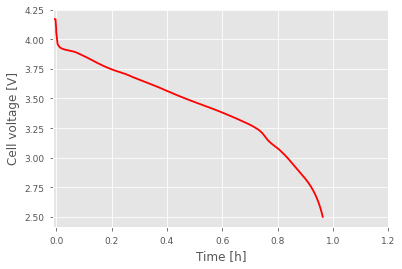

In [5]:
plt.plot(times,voltage,'r-',label='Simulation')
plt.xlabel("Time [h]")
plt.ylabel("Cell voltage [V]")
plt.xlim([-0.01, 1.2])

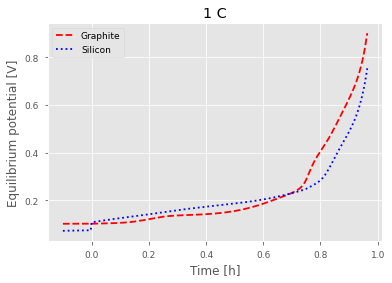

In [6]:
plt.plot(times,ocp_p1,'r--',label='Graphite')
plt.plot(times,ocp_p2,'b:',label='Silicon')
plt.xlabel("Time [h]")
plt.ylabel("Equilibrium potential [V]")
plt.title(str(C_rates)+" C")
plt.legend()
# plt.xlim([100, 103])
# plt.ylim([0.4, 1])

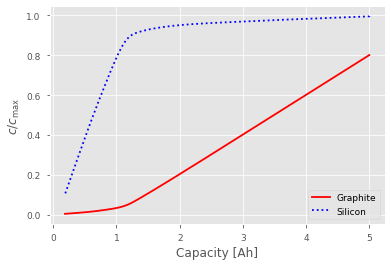

In [7]:
c_s_xrav_n_p1 = solution["Averaged negative electrode concentration of phase 1"].entries
c_s_xrav_n_p2 = solution["Averaged negative electrode concentration of phase 2"].entries
plt.plot(capacity, c_s_xrav_n_p1,'r-', label='Graphite')
plt.plot(capacity, c_s_xrav_n_p2, 'b:',label='Silicon')
plt.xlabel("Capacity [Ah]")
plt.ylabel("$c/c_\mathrm{max}$")
# plt.ylim([0,0.02])
plt.legend()

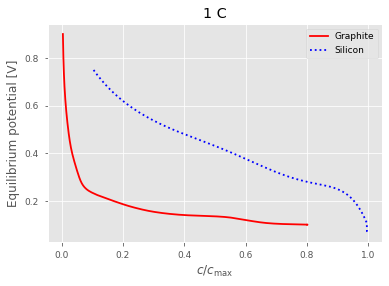

In [8]:
plt.plot(c_s_xrav_n_p1, ocp_p1,'r-', label='Graphite')
plt.plot(c_s_xrav_n_p2, ocp_p2, 'b:',label='Silicon')
plt.xlabel("$c/c_\mathrm{max}$")
plt.ylabel("Equilibrium potential [V]")
plt.title(str(C_rates)+" C")
# plt.ylim([0,0.02])
plt.legend()

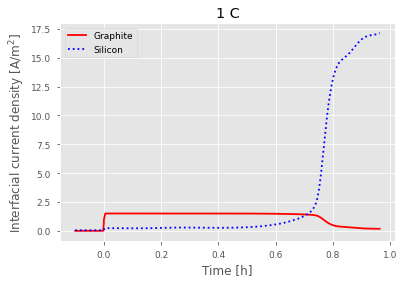

In [9]:
j_n_p1_av = solution["X-averaged negative electrode interfacial current density of phase 1 [A.m-2]"].entries
j_n_p2_av = solution["X-averaged negative electrode interfacial current density of phase 2 [A.m-2]"].entries
plt.plot(times, j_n_p1_av,'r-', label='Graphite')
plt.plot(times, j_n_p2_av, 'b:',label='Silicon')
plt.xlabel("Time [h]")
plt.ylabel("Interfacial current density [A/m$^{2}$]")
# plt.ylim([-0.2, 0.8])
# plt.xlim([96, 102])
plt.title(str(C_rates)+" C")
plt.legend()

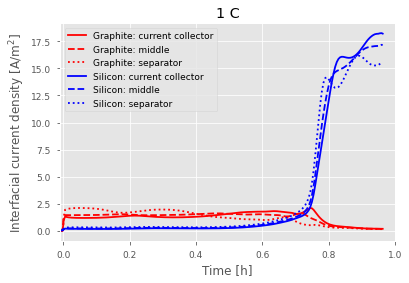

In [10]:
j_n_p1 = solution["Negative electrode interfacial current density of phase 1 [A.m-2]"].entries
j_n_p2 = solution["Negative electrode interfacial current density of phase 2 [A.m-2]"].entries
plt.plot(times, j_n_p1[0,:],'r-', label='Graphite: current collector')
plt.plot(times, j_n_p1[10,:], 'r--',label='Graphite: middle')
plt.plot(times, j_n_p1[-1,:], 'r:',label='Graphite: separator')
plt.plot(times, j_n_p2[0,:],'b-', label='Silicon: current collector')
plt.plot(times, j_n_p2[10,:], 'b--',label='Silicon: middle')
plt.plot(times, j_n_p2[-1,:], 'b:',label='Silicon: separator')
plt.xlabel("Time [h]")
plt.ylabel("Interfacial current density [A/m$^{2}$]")
# plt.ylim([-0.2, 0.8])
plt.xlim([-0.01, 1])
plt.title(str(C_rates)+" C")
plt.legend()

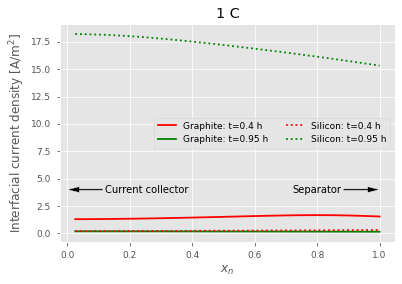

In [11]:
j_n_p1 = solution["Negative electrode interfacial current density of phase 1 [A.m-2]"].entries
j_n_p2 = solution["Negative electrode interfacial current density of phase 2 [A.m-2]"].entries
x0 = np.linspace(0.025, 1, num=20)
#v0=[101,161,221,276]
v0=[161,270]
ltype1=['r-','g-','b-','k-','c-'];
ltype2=['r:','g:','b:','k:','c:'];
for i in range(0,len(v0)):
    plt.plot(x0, j_n_p1[:,v0[i]],ltype1[i], label='Graphite: t='+str(np.round(times[v0[i]],decimals=2))+' h')
for i in range(0,len(v0)):
    plt.plot(x0, j_n_p2[:,v0[i]],ltype2[i],label='Silicon: t='+str(np.round(times[v0[i]],decimals=2))+' h')

plt.xlabel("$x_n$")
plt.ylabel("Interfacial current density [A/m$^{2}$]")
plt.annotate('Current collector', xy=(0, 4), xycoords='data', xytext=(0.12, 4), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
plt.annotate('Separator', xy=(1, 4), xycoords='data', xytext=(0.72, 4), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
# plt.annotate('Current collector',(0.1,5),)
# plt.ylim([-0.2, 0.8])
# plt.xlim([96, 102])
plt.title(str(C_rates)+" C")
plt.legend(ncol=2)

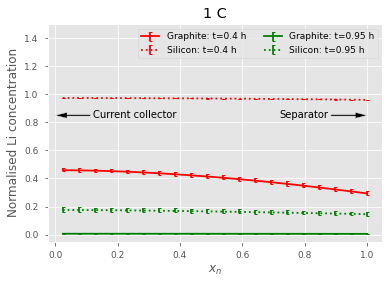

In [12]:
c_s_n_p1 = solution["Negative electrode concentration of phase 1"].entries
c_s_n_p2 = solution["Negative electrode concentration of phase 2"].entries
c_s_rav_n_p1 = solution["R-averaged negative particle concentration of phase 1"].entries
c_s_rav_n_p2 = solution["R-averaged negative particle concentration of phase 2"].entries
for i in range(0,len(v0)):
    err1=c_s_n_p1[0,:,v0[i]]-c_s_rav_n_p1[:,v0[i]]
    err2=c_s_rav_n_p1[:,v0[i]]-c_s_n_p1[-1,:,v0[i]]
    plt.errorbar(x0, c_s_rav_n_p1[:,v0[i]],yerr=[err2,err1],fmt=ltype1[i],label='Graphite: t='+str(np.round(times[v0[i]],decimals=2))+' h',capsize=1.5)
    err1=c_s_n_p2[0,:,v0[i]]-c_s_rav_n_p2[:,v0[i]]
    err2=c_s_rav_n_p2[:,v0[i]]-c_s_n_p2[-1,:,v0[i]]
    plt.errorbar(x0, c_s_rav_n_p2[:,v0[i]],yerr=[err2,err1],fmt=ltype2[i],label='Silicon: t='+str(np.round(times[v0[i]],decimals=2))+' h',capsize=1.5)

plt.xlabel("$x_n$")
plt.ylabel("Normalised Li concentration")
plt.annotate('Current collector', xy=(0, 0.85), xycoords='data', xytext=(0.12, 0.85), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
plt.annotate('Separator', xy=(1, 0.85), xycoords='data', xytext=(0.72, 0.85), textcoords='data',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
# plt.annotate('Current collector',(0.1,5),)
plt.ylim([-0.05, 1.5])
# plt.xlim([96, 102])
plt.title(str(C_rates)+" C")
plt.legend(ncol=2, loc = 'upper right')

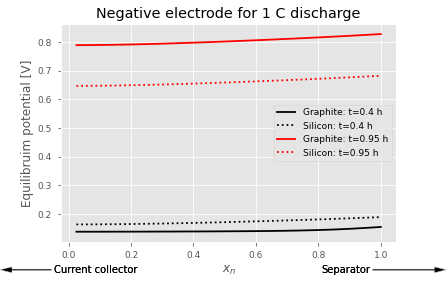

In [13]:
x0 = np.linspace(0.025, 1, num=20)
#v0 = [105,142]
ltype1=['k-','r-','b-','g-','m-','c-','y-'];
ltype2=['k:','r:','b:','g:','m:','c:','y:'];
plt.figure()
t_i = solution["Time [s]"].entries / 3600
ocp_n_p1 = solution["Negative electrode open circuit potential of phase 1 [V]"].entries
ocp_n_p2 = solution["Negative electrode open circuit potential of phase 2 [V]"].entries
for i in range(0,len(v0)):
    vj=v0[i]
    if vj > len(t_i)-1:
        vj = len(t_i)-1

    plt.plot(x0, ocp_n_p1[:,vj],ltype1[i],label='Graphite: t='+str(np.round(times[v0[i]],decimals=2))+' h')
    plt.plot(x0, ocp_n_p2[:,vj],ltype2[i],label='Silicon: t='+str(np.round(times[v0[i]],decimals=2))+' h')

    plt.xlabel("$x_n$")
    plt.ylabel("Equilibruim potential [V]")
    plt.annotate('Current collector', xy=(0, 0.05), xycoords='figure fraction', xytext=(0.12, 0.05), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    plt.annotate('Separator', xy=(1, 0.05), xycoords='figure fraction', xytext=(0.72, 0.05), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
    # plt.annotate('Current collector',(0.1,5),)  

    # plt.ylim([-0.05, 1.1])
    # plt.xlim([96, 102])
    plt.title('Negative electrode for '+str(C_rates)+" C discharge")
#plt.text(-0.15,-0.32,'Graphite') 
#plt.text(-0.13,-0.42,'Silicon') 
plt.legend()

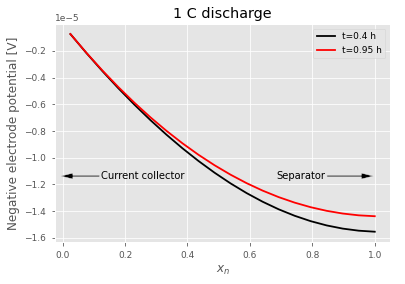

In [14]:
x0 = np.linspace(0.025, 1, num=20)
#v0 = [105,142]
ltype1=['k-','r-','b-','g-','m-','c-','y-'];
ltype2=['k:','r:','b:','g:','m:','c:','y:'];
t_i = solution["Time [s]"].entries / 3600
Psi_s_n = solution["Negative electrode potential [V]"].entries
for i in range(0,len(v0)):
    vj=v0[i]
    if vj > len(t_i)-1:
        vj = len(t_i)-1
    plt.plot(x0, Psi_s_n[:,vj],ltype1[i],label='t='+str(np.round(times[v0[i]],decimals=2))+' h')
plt.xlabel("$x_n$")
plt.ylabel("Negative electrode potential [V]")
plt.annotate('Current collector', xy=(0.15, 0.38), xycoords='figure fraction', xytext=(0.25, 0.38), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
plt.annotate('Separator', xy=(0.92, 0.38), xycoords='figure fraction', xytext=(0.68, 0.38), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
# plt.annotate('Current collector',(0.1,5),)  
# plt.ylim([-0.05, 1.1])
# plt.xlim([96, 102])
plt.title(str(C_rates)+" C discharge")
#plt.text(-0.15,-0.32,'Graphite') 
#plt.text(-0.13,-0.42,'Silicon') 
plt.legend()

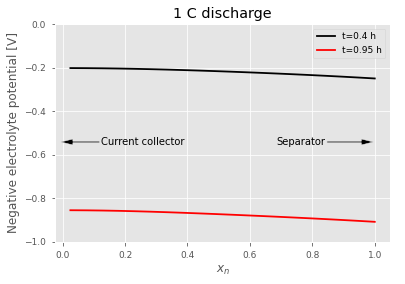

In [15]:
x0 = np.linspace(0.025, 1, num=20)
#v0 = [105,142]
ltype1=['k-','r-','b-','g-','m-','c-','y-'];
ltype2=['k:','r:','b:','g:','m:','c:','y:'];
t_i = solution["Time [s]"].entries / 3600
Psi_e_n = solution["Electrolyte potential [V]"].entries
for i in range(0,len(v0)):
    vj=v0[i]
    if vj > len(t_i)-1:
        vj = len(t_i)-1
    plt.plot(x0, Psi_e_n[0:20,vj],ltype1[i],label='t='+str(np.round(times[v0[i]],decimals=2))+' h')
plt.xlabel("$x_n$")
plt.ylabel("Negative electrolyte potential [V]")
plt.annotate('Current collector', xy=(0.15, 0.5), xycoords='figure fraction', xytext=(0.25, 0.5), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
plt.annotate('Separator', xy=(0.92, 0.5), xycoords='figure fraction', xytext=(0.68, 0.5), textcoords='figure fraction',arrowprops=dict(facecolor="black",width=1.5,headwidth=6),va='center')
# plt.annotate('Current collector',(0.1,5),)  
plt.ylim([-1, 0])
# plt.xlim([96, 102])
plt.title(str(C_rates)+" C discharge")
#plt.text(-0.15,-0.32,'Graphite') 
#plt.text(-0.13,-0.42,'Silicon') 
plt.legend()

In [17]:
# save all data
err1_p1=c_s_n_p1[0,:,:] - c_s_rav_n_p1[:,:]
err2_p1=c_s_rav_n_p1[:,:]-c_s_n_p1[-1,:,:]
err1_p2=c_s_n_p2[0,:,:] - c_s_rav_n_p2[:,:]
err2_p2=c_s_rav_n_p2[:,:]-c_s_n_p2[-1,:,:]  
times0= np.reshape(times[v0],(2,-1))
headstr="times, j_n_p1, j_n_p2, c_s_rav_n_p1, err1_p1, err2_p1, c_s_rav_n_p2, err1_p2, err2_p2, ocp_n_p1, ocp_n_p2"
outputs=np.hstack((times0,j_n_p1[:,v0].T, j_n_p2[:,v0].T, c_s_rav_n_p1[:,v0].T, err1_p1[:,v0].T, err2_p1[:,v0].T, c_s_rav_n_p2[:,v0].T, err1_p2[:,v0].T, err2_p2[:,v0].T, ocp_n_p1[:,v0].T, ocp_n_p2[:,v0].T))
np.savetxt('wip/data/local_1C.txt', outputs, delimiter=',', header=headstr,fmt='%1.6f')  # X is an array

In [16]:
return

SyntaxError: 'return' outside function (<ipython-input-16-9b32c1431b19>, line 1)

In [ ]:
print(np.shape(times))
print(times)